# ANALISIS EXPLORATORIO DE DATOS -  SISTEMA DE VIDEO ANOTACION


## Integrantes

- Darwin Lenis
- Juan Felipe Madrid
- Jacobo Ossa
- Luis Pinillos

## 1.Introduccion:

Este proyecto tiene como objetivo desarrollar una herramienta de software que analice actividades humanas específicas de movimiento (como caminar, girar, sentarse y ponerse de pie) utilizando un sistema de video en tiempo real. La solución se centra en el seguimiento de movimientos articulares y posturales, y proporciona clasificaciones y análisis en tiempo real a traves del entrenamiento de varios modelos de inteligencia artificial que permitan la clasificacion de estos movimientos.

## 2.Proceso de Recolección y Análisis de Datos



### 2.1 Grabación de Videos:



  Para emperzar con el desarrollo del proyecto es necesario tener un dataset que nos permita hacer el entrenamiento y prueba de los modelos a entrenar, para esto y teniendo en cuenta que lo que buscamos es clasificar movimientos en tiempo real, se grabaron distintas personas realizando movimientos como sentarse, caminar, girar, inclinarse, alejarse y acercarse desde un punto fijo. De estos videos se espera sacar los datos necesarios para crear el dataset base.

  

### 2.2 Análisis con MediaPipe:


De la grabacion del video no se pueden sacar datos por si solo, por lo cual es necesario hacer uso de una herramientas que nos permita hacerlo. Por lo anterior, se utilizó MediaPipe que es una plataforma de Google desarrollada para crear soluciones de procesamiento de visión por computadora y aprendizaje automático. Ofrece una serie de herramientas y modelos listos para usar que pueden ser integrados en aplicaciones para tareas como la detección de rostros, el seguimiento de manos, la estimación de poses corporales, la segmentación de objetos, y más. Especificamente se uso la seccion de "detección de puntos de referencia de posiciones", ya que esto nos permite hacer un seguimiento de cuerpo completo de los videos grabados.

https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419

MediaPipe procesa los videos para identificar 33 articulaciones del cuerpo humano en cada frame, cada articulacion que su respectivo identificador, incluyendo:
* Cabeza (nariz, ojos, orejas)
* Hombros, codos, muñecas, manos
* Caderas, rodillas, tobillos, pies




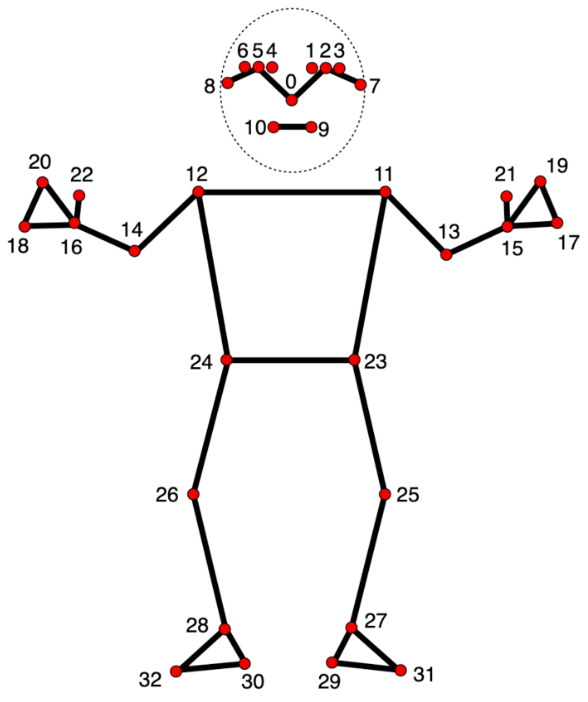

- 0 - nose
- 1 - left eye (inner)
- 2 - left eye
- 3 - left eye (outer)
- 4 - right eye (inner)
- 5 - right eye
- 6 - right eye (outer)
- 7 - left ear
- 8 - right ear
- 9 - mouth (left)
- 10 - mouth (right)
- 11 - left shoulder
- 12 - right shoulder
- 13 - left elbow
- 14 - right elbow
- 15 - left wrist
- 16 - right wrist
- 17 - left pinky
- 18 - right pinky
- 19 - left index
- 20 - right index
- 21 - left thumb
- 22 - right thumb
- 23 - left hip
- 24 - right hip
- 25 - left knee
- 26 - right knee
- 27 - left ankle
- 28 - right ankle
- 29 - left heel
- 30 - right heel
- 31 - left foot index
- 32 - right foot index

### 2.3 Generación de Datos:







Con la ayuda MediaPipe se generaron coordenadas tridimensionales (x, y, z) para cada articulación. Estos datos son los que haran parte del dataset base.

Lo primero que se hizo fue establecer la etiqueta que actuara como clase, esto permitira diferencia que se esta haciendo en cada frame del dataset y a medida que se analiza el video, extrae las coordenadas tridimensionales

Un aspecto muy importante es que se decidio agrupar cada 5 frames, esto con el proposito de que el entrenamiento del modelo fuera correcto, ya que si se dejan los datos frame por frame el modelo no va a detectar un cambio significativo en las coordenadas. Asi que al juntar por grupos a los frames, se va a poder diferenciar el cambio de coordenadas en los diferentes movimientos, lo que le da contexto al modelo sobre cómo se mueve el cuerpo a través del tiempo. El hecho de que el cuerpo cambie de posición en varias articulaciones a lo largo de varios frames es clave para que el modelo aprenda patrones temporales y entienda el contexto de lo que está viendo, si solo les das información de un frame, no pueden ver ese cambio.

Adicionalmente, estos datos se guardan de forma vectorial, lo que es importante para que el modelo de IA pueda procesar estos datos eficientemente. Los modelos de IA están optimizados para trabajar con vectores de características, donde cada característica (en este caso, cada coordenada X, Y, Z a lo largo de varios frames) ayuda a definir el patrón de movimiento en la actividad humana.

Ventajas de agrupar en vectores:

* **Mejor representación del movimiento:** Al agrupar varios frames en un vector, el modelo puede ver cómo cambian las articulaciones a lo largo de varios momentos, lo que es crucial para detectar patrones de movimiento.
* **Menos datos, más información:** En lugar de procesar cada frame individualmente (lo que haría que el modelo trate de entender el movimiento solo a partir de un frame), el modelo puede ver una secuencia de frames y entender el movimiento en conjunto, lo cual es más efectivo para entrenar.
* **Reducción de ruido:** Si el modelo viera cada frame individualmente, podría sobreajustarse a pequeños cambios aleatorios que ocurren en un solo frame. Al ver un grupo de frames, el modelo puede aprender el patrón general del movimiento y no distraerse con pequeñas variaciones.


Para cada frame:
* 495 columnas de coordenadas (33 articulaciones * 3 coordenadas)
* 1 columna de etiqueta de actividad

Estructura del Dataset:
* 495 columnas: coordenadas de articulaciones
* 1 columna: etiqueta de actividad (ej. "Sentarse", "Girando")

Ya con cada dataset extraido de cada uno de los videos, se concatenaron todos para tener un solo dataset con toda la informacion.


#### Codigo usado para el extraccion de datos de los videos grabados:

In [ ]:
import cv2
import mediapipe as mp
import csv
import numpy as np

# Inicializamos MediaPipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Etiqueta de la acción (puedes cambiarla dependiendo del video que proceses)
action_label = "Sentarse"

# Ruta del video (puedes cambiarla según el video que proceses)
video_path = './Desktop/ProyectoIA/Entrega1/Videos/Sentado_User4.mp4'
cap = cv2.VideoCapture(video_path)

# Abrimos un archivo CSV para guardar los datos del dataset
with open('./Desktop/ProyectoIA/Entrega1/Dataset_Info/dataset_sentarse_user4.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Escribimos el encabezado del CSV
    header = ['label']
    for frame_idx in range(5):  # 5 frames agrupados
        for i in range(33):  # 33 puntos mapeados
            header += [f'x{frame_idx}_{i}', f'y{frame_idx}_{i}', f'z{frame_idx}_{i}']
    writer.writerow(header)

    # Variables para agrupar los frames
    group_of_frames = []
    frame_counter = 0

    # Procesamos cada frame del video
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Convertimos el frame de BGR a RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Procesamos el frame con MediaPipe para detectar las articulaciones
        results = pose.process(rgb_frame)

        # Si se detectan las articulaciones
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            frame_data = []

            # Extraemos las coordenadas x, y, z de cada articulación
            for landmark in landmarks:
                frame_data.append(landmark.x)
                frame_data.append(landmark.y)
                frame_data.append(landmark.z)

            # Añadimos las coordenadas del frame actual al grupo de frames
            group_of_frames.append(frame_data)
            frame_counter += 1

            # Cuando se tienen 5 frames, concatenamos las coordenadas en un solo vector
            if frame_counter == 5:
                combined_vector = [action_label]  # Añadimos la etiqueta al inicio
                for frame in group_of_frames:
                    combined_vector.extend(frame)  # Concatenamos las coordenadas de los 5 frames

                # Escribimos el vector combinado en el CSV
                writer.writerow(combined_vector)

                # Reiniciamos el contador y el buffer de frames
                group_of_frames = []
                frame_counter = 0

# Liberamos los recursos utilizados
cap.release()
cv2.destroyAllWindows()

## 3.Analisis Exploratorio

Ya teniendo el dataset necesario podemos empezar con su respectivo analisis exploratorio. En este caso, no es necesario realizar correcciones en el dataset generado, ya que los datos están bien estructurados y en el formato correcto. El código que los procesa asegura que las coordenadas de las articulaciones se registren de manera consistente y se almacenen adecuadamente en el archivo CSV, listo para su análisis y uso en modelos de aprendizaje automático.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('/content/todos_los_datos.csv', na_values=[' ',''])

In [3]:
df.shape

(475, 496)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Columns: 496 entries, label to z4_32
dtypes: float64(495), object(1)
memory usage: 1.8+ MB


In [5]:
df.head(5)

,label,x0_0,y0_0,z0_0,x0_1,y0_1,z0_1,x0_2,y0_2,z0_2,x0_3,y0_3,z0_3,x0_4,y0_4,z0_4,x0_5,y0_5,z0_5,x0_6,y0_6,z0_6,x0_7,y0_7,z0_7,x0_8,y0_8,z0_8,x0_9,y0_9,z0_9,x0_10,y0_10,z0_10,x0_11,y0_11,z0_11,x0_12,y0_12,z0_12,x0_13,y0_13,z0_13,x0_14,y0_14,z0_14,x0_15,y0_15,z0_15,x0_16,y0_16,z0_16,x0_17,y0_17,z0_17,x0_18,y0_18,z0_18,x0_19,y0_19,z0_19,x0_20,y0_20,z0_20,x0_21,y0_21,z0_21,x0_22,y0_22,z0_22,x0_23,y0_23,z0_23,x0_24,y0_24,z0_24,x0_25,y0_25,z0_25,x0_26,y0_26,z0_26,x0_27,y0_27,z0_27,x0_28,y0_28,z0_28,x0_29,y0_29,z0_29,x0_30,y0_30,z0_30,x0_31,y0_31,z0_31,x0_32,y0_32,z0_32,x1_0,y1_0,z1_0,x1_1,y1_1,z1_1,x1_2,y1_2,z1_2,x1_3,y1_3,z1_3,x1_4,y1_4,z1_4,x1_5,y1_5,z1_5,x1_6,y1_6,z1_6,x1_7,y1_7,z1_7,x1_8,y1_8,z1_8,x1_9,y1_9,z1_9,x1_10,y1_10,z1_10,x1_11,y1_11,z1_11,x1_12,y1_12,z1_12,x1_13,y1_13,z1_13,x1_14,y1_14,z1_14,x1_15,y1_15,z1_15,x1_16,y1_16,z1_16,x1_17,y1_17,z1_17,x1_18,y1_18,z1_18,x1_19,y1_19,z1_19,x1_20,y1_20,z1_20,x1_21,y1_21,z1_21,x1_22,y1_22,z1_22,x1_23,y1_23,z1_23,x1_24,y1_24,z1_24,x1_25,y1_25,z1_25,x1_26,y1_26,z1_26,x1_27,y1_27,z1_27,x1_28,y1_28,z1_28,x1_29,y1_29,z1_29,x1_30,y1_30,z1_30,x1_31,y1_31,z1_31,x1_32,y1_32,z1_32,x2_0,y2_0,z2_0,x2_1,y2_1,z2_1,x2_2,y2_2,z2_2,x2_3,y2_3,z2_3,x2_4,y2_4,z2_4,x2_5,y2_5,z2_5,x2_6,y2_6,z2_6,x2_7,y2_7,z2_7,x2_8,y2_8,z2_8,x2_9,y2_9,z2_9,x2_10,y2_10,z2_10,x2_11,y2_11,z2_11,x2_12,y2_12,z2_12,x2_13,y2_13,z2_13,x2_14,y2_14,z2_14,x2_15,y2_15,z2_15,x2_16,y2_16,z2_16,x2_17,y2_17,z2_17,x2_18,y2_18,z2_18,x2_19,y2_19,z2_19,x2_20,y2_20,z2_20,x2_21,y2_21,z2_21,x2_22,y2_22,z2_22,x2_23,y2_23,z2_23,x2_24,y2_24,z2_24,x2_25,y2_25,z2_25,x2_26,y2_26,z2_26,x2_27,y2_27,z2_27,x2_28,y2_28,z2_28,x2_29,y2_29,z2_29,x2_30,y2_30,z2_30,x2_31,y2_31,z2_31,x2_32,y2_32,z2_32,x3_0,y3_0,z3_0,x3_1,y3_1,z3_1,x3_2,y3_2,z3_2,x3_3,y3_3,z3_3,x3_4,y3_4,z3_4,x3_5,y3_5,z3_5,x3_6,y3_6,z3_6,x3_7,y3_7,z3_7,x3_8,y3_8,z3_8,x3_9,y3_9,z3_9,x3_10,y3_10,z3_10,x3_11,y3_11,z3_11,x3_12,y3_12,z3_12,x3_13,y3_13,z3_13,x3_14,y3_14,z3_14,x3_15,y3_15,z3_15,x3_16,y3_16,z3_16,x3_17,y3_17,z3_17,x3_18,y3_18,z3_18,x3_19,y3_19,z3_19,x3_20,y3_20,z3_20,x3_21,y3_21,z3_21,x3_22,y3_22,z3_22,x3_23,y3_23,z3_23,x3_24,y3_24,z3_24,x3_25,y3_25,z3_25,x3_26,y3_26,z3_26,x3_27,y3_27,z3_27,x3_28,y3_28,z3_28,x3_29,y3_29,z3_29,x3_30,y3_30,z3_30,x3_31,y3_31,z3_31,x3_32,y3_32,z3_32,x4_0,y4_0,z4_0,x4_1,y4_1,z4_1,x4_2,y4_2,z4_2,x4_3,y4_3,z4_3,x4_4,y4_4,z4_4,x4_5,y4_5,z4_5,x4_6,y4_6,z4_6,x4_7,y4_7,z4_7,x4_8,y4_8,z4_8,x4_9,y4_9,z4_9,x4_10,y4_10,z4_10,x4_11,y4_11,z4_11,x4_12,y4_12,z4_12,x4_13,y4_13,z4_13,x4_14,y4_14,z4_14,x4_15,y4_15,z4_15,x4_16,y4_16,z4_16,x4_17,y4_17,z4_17,x4_18,y4_18,z4_18,x4_19,y4_19,z4_19,x4_20,y4_20,z4_20,x4_21,y4_21,z4_21,x4_22,y4_22,z4_22,x4_23,y4_23,z4_23,x4_24,y4_24,z4_24,x4_25,y4_25,z4_25,x4_26,y4_26,z4_26,x4_27,y4_27,z4_27,x4_28,y4_28,z4_28,x4_29,y4_29,z4_29,x4_30,y4_30,z4_30,x4_31,y4_31,z4_31,x4_32,y4_32,z4_32
0,Sentarse,0.723779,0.219818,0.082848,0.713928,0.205817,0.106136,0.710933,0.205306,0.106105,0.707636,0.204595,0.106178,0.714295,0.204940,0.026574,0.712012,0.203976,0.026577,0.709605,0.202896,0.026344,0.678445,0.206295,0.214559,0.686961,0.205473,-0.142611,0.712794,0.231697,0.133130,0.712725,0.230132,0.029123,0.592530,0.271902,0.426716,0.655522,0.258185,-0.384119,0.591113,0.378678,0.470302,0.666792,0.373947,-0.509015,0.624065,0.467323,0.366442,0.732023,0.474098,-0.490775,0.623438,0.492548,0.383645,0.750715,0.504812,-0.553790,0.653945,0.489292,0.324909,0.757416,0.504195,-0.514516,0.653187,0.482711,0.334710,0.751127,0.495227,-0.471963,0.614939,0.480106,0.251416,0.663062,0.477103,-0.251612,0.648745,0.636982,0.287640,0.675858,0.640564,-0.188282,0.644726,0.802912,0.387038,0.663555,0.819203,-0.130728,0.609211,0.822148,0.386004,0.632006,0.846681,-0.134996,0.747641,0.826612,0.276757,0.807079,0.853367,-0.308416,0.723837,0.219990,0.084391,0.714056,0.206253,0.109092,0.711104,0.205897,0.109031,0.707846,0.205364,0.109092,0.714565,0.205384,0.030089,0.712514,0.204592,0.030086,0.710399,0.203739,0.029840,0.679006,0.207193,0.222788,0.688125,0.206575,-0.128454,0.712987,0.2321

In [6]:
df.tail(5)

,label,x0_0,y0_0,z0_0,x0_1,y0_1,z0_1,x0_2,y0_2,z0_2,x0_3,y0_3,z0_3,x0_4,y0_4,z0_4,x0_5,y0_5,z0_5,x0_6,y0_6,z0_6,x0_7,y0_7,z0_7,x0_8,y0_8,z0_8,x0_9,y0_9,z0_9,x0_10,y0_10,z0_10,x0_11,y0_11,z0_11,x0_12,y0_12,z0_12,x0_13,y0_13,z0_13,x0_14,y0_14,z0_14,x0_15,y0_15,z0_15,x0_16,y0_16,z0_16,x0_17,y0_17,z0_17,x0_18,y0_18,z0_18,x0_19,y0_19,z0_19,x0_20,y0_20,z0_20,x0_21,y0_21,z0_21,x0_22,y0_22,z0_22,x0_23,y0_23,z0_23,x0_24,y0_24,z0_24,x0_25,y0_25,z0_25,x0_26,y0_26,z0_26,x0_27,y0_27,z0_27,x0_28,y0_28,z0_28,x0_29,y0_29,z0_29,x0_30,y0_30,z0_30,x0_31,y0_31,z0_31,x0_32,y0_32,z0_32,x1_0,y1_0,z1_0,x1_1,y1_1,z1_1,x1_2,y1_2,z1_2,x1_3,y1_3,z1_3,x1_4,y1_4,z1_4,x1_5,y1_5,z1_5,x1_6,y1_6,z1_6,x1_7,y1_7,z1_7,x1_8,y1_8,z1_8,x1_9,y1_9,z1_9,x1_10,y1_10,z1_10,x1_11,y1_11,z1_11,x1_12,y1_12,z1_12,x1_13,y1_13,z1_13,x1_14,y1_14,z1_14,x1_15,y1_15,z1_15,x1_16,y1_16,z1_16,x1_17,y1_17,z1_17,x1_18,y1_18,z1_18,x1_19,y1_19,z1_19,x1_20,y1_20,z1_20,x1_21,y1_21,z1_21,x1_22,y1_22,z1_22,x1_23,y1_23,z1_23,x1_24,y1_24,z1_24,x1_25,y1_25,z1_25,x1_26,y1_26,z1_26,x1_27,y1_27,z1_27,x1_28,y1_28,z1_28,x1_29,y1_29,z1_29,x1_30,y1_30,z1_30,x1_31,y1_31,z1_31,x1_32,y1_32,z1_32,x2_0,y2_0,z2_0,x2_1,y2_1,z2_1,x2_2,y2_2,z2_2,x2_3,y2_3,z2_3,x2_4,y2_4,z2_4,x2_5,y2_5,z2_5,x2_6,y2_6,z2_6,x2_7,y2_7,z2_7,x2_8,y2_8,z2_8,x2_9,y2_9,z2_9,x2_10,y2_10,z2_10,x2_11,y2_11,z2_11,x2_12,y2_12,z2_12,x2_13,y2_13,z2_13,x2_14,y2_14,z2_14,x2_15,y2_15,z2_15,x2_16,y2_16,z2_16,x2_17,y2_17,z2_17,x2_18,y2_18,z2_18,x2_19,y2_19,z2_19,x2_20,y2_20,z2_20,x2_21,y2_21,z2_21,x2_22,y2_22,z2_22,x2_23,y2_23,z2_23,x2_24,y2_24,z2_24,x2_25,y2_25,z2_25,x2_26,y2_26,z2_26,x2_27,y2_27,z2_27,x2_28,y2_28,z2_28,x2_29,y2_29,z2_29,x2_30,y2_30,z2_30,x2_31,y2_31,z2_31,x2_32,y2_32,z2_32,x3_0,y3_0,z3_0,x3_1,y3_1,z3_1,x3_2,y3_2,z3_2,x3_3,y3_3,z3_3,x3_4,y3_4,z3_4,x3_5,y3_5,z3_5,x3_6,y3_6,z3_6,x3_7,y3_7,z3_7,x3_8,y3_8,z3_8,x3_9,y3_9,z3_9,x3_10,y3_10,z3_10,x3_11,y3_11,z3_11,x3_12,y3_12,z3_12,x3_13,y3_13,z3_13,x3_14,y3_14,z3_14,x3_15,y3_15,z3_15,x3_16,y3_16,z3_16,x3_17,y3_17,z3_17,x3_18,y3_18,z3_18,x3_19,y3_19,z3_19,x3_20,y3_20,z3_20,x3_21,y3_21,z3_21,x3_22,y3_22,z3_22,x3_23,y3_23,z3_23,x3_24,y3_24,z3_24,x3_25,y3_25,z3_25,x3_26,y3_26,z3_26,x3_27,y3_27,z3_27,x3_28,y3_28,z3_28,x3_29,y3_29,z3_29,x3_30,y3_30,z3_30,x3_31,y3_31,z3_31,x3_32,y3_32,z3_32,x4_0,y4_0,z4_0,x4_1,y4_1,z4_1,x4_2,y4_2,z4_2,x4_3,y4_3,z4_3,x4_4,y4_4,z4_4,x4_5,y4_5,z4_5,x4_6,y4_6,z4_6,x4_7,y4_7,z4_7,x4_8,y4_8,z4_8,x4_9,y4_9,z4_9,x4_10,y4_10,z4_10,x4_11,y4_11,z4_11,x4_12,y4_12,z4_12,x4_13,y4_13,z4_13,x4_14,y4_14,z4_14,x4_15,y4_15,z4_15,x4_16,y4_16,z4_16,x4_17,y4_17,z4_17,x4_18,y4_18,z4_18,x4_19,y4_19,z4_19,x4_20,y4_20,z4_20,x4_21,y4_21,z4_21,x4_22,y4_22,z4_22,x4_23,y4_23,z4_23,x4_24,y4_24,z4_24,x4_25,y4_25,z4_25,x4_26,y4_26,z4_26,x4_27,y4_27,z4_27,x4_28,y4_28,z4_28,x4_29,y4_29,z4_29,x4_30,y4_30,z4_30,x4_31,y4_31,z4_31,x4_32,y4_32,z4_32
470,Alejandose,0.500143,0.348387,0.411679,0.493254,0.340755,0.348013,0.488042,0.340763,0.348038,0.482586,0.340938,0.348019,0.508398,0.340471,0.359978,0.514022,0.340300,0.360010,0.519947,0.340122,0.359915,0.475466,0.345776,0.120184,0.527458,0.344548,0.175577,0.493766,0.355805,0.340693,0.509776,0.355916,0.354610,0.417613,0.398769,-0.017912,0.586248,0.397631,0.083604,0.393278,0.479535,-0.047592,0.617369,0.470832,0.054612,0.408133,0.544257,0.001605,0.631674,0.536820,0.030983,0.407695,0.562271,-0.009081,0.633087,0.554549,0.026932,0.416999,0.560133,-0.010235,0.628433,0.553190,0.021132,0.419595,0.553432,0.001956,0.624159,0.547947,0.027971,0.453243,0.542940,-0.041993,0.545796,0.541673,0.041837,0.467140,0.651474,-0.034293,0.556839,0.648433,0.125562,0.484745,0.762426,0.018359,0.562064,0.750105,0.196214,0.489389,0.778941,0.021168,0.558730,0.768524,0.201449,0.463142,0.766732,-0.060400,0.560488,0.755000,0.131733,0.505085,0.349725,0.401995,0.497754,0.342136,0.338550,0.492646,0.342104,0.338588,0.487174,0.342245,0.338588,0.513032,0.341831,0.349280,0.518573,0.341642,0.349297,0.524602,0.341421,0.349204,0.479938,0.346914,0.112936,0.532218,0.345613,0.159506,0.498755,0.357028

In [ ]:
df.describe()

,x0_0,y0_0,z0_0,x0_1,y0_1,z0_1,x0_2,y0_2,z0_2,x0_3,y0_3,z0_3,x0_4,y0_4,z0_4,x0_5,y0_5,z0_5,x0_6,y0_6,z0_6,x0_7,y0_7,z0_7,x0_8,y0_8,z0_8,x0_9,y0_9,z0_9,x0_10,y0_10,z0_10,x0_11,y0_11,z0_11,x0_12,y0_12,z0_12,x0_13,y0_13,z0_13,x0_14,y0_14,z0_14,x0_15,y0_15,z0_15,x0_16,y0_16,z0_16,x0_17,y0_17,z0_17,x0_18,y0_18,z0_18,x0_19,y0_19,z0_19,x0_20,y0_20,z0_20,x0_21,y0_21,z0_21,x0_22,y0_22,z0_22,x0_23,y0_23,z0_23,x0_24,y0_24,z0_24,x0_25,y0_25,z0_25,x0_26,y0_26,z0_26,x0_27,y0_27,z0_27,x0_28,y0_28,z0_28,x0_29,y0_29,z0_29,x0_30,y0_30,z0_30,x0_31,y0_31,z0_31,x0_32,y0_32,z0_32,x1_0,y1_0,z1_0,x1_1,y1_1,z1_1,x1_2,y1_2,z1_2,x1_3,y1_3,z1_3,x1_4,y1_4,z1_4,x1_5,y1_5,z1_5,x1_6,y1_6,z1_6,x1_7,y1_7,z1_7,x1_8,y1_8,z1_8,x1_9,y1_9,z1_9,x1_10,y1_10,z1_10,x1_11,y1_11,z1_11,x1_12,y1_12,z1_12,x1_13,y1_13,z1_13,x1_14,y1_14,z1_14,x1_15,y1_15,z1_15,x1_16,y1_16,z1_16,x1_17,y1_17,z1_17,x1_18,y1_18,z1_18,x1_19,y1_19,z1_19,x1_20,y1_20,z1_20,x1_21,y1_21,z1_21,x1_22,y1_22,z1_22,x1_23,y1_23,z1_23,x1_24,y1_24,z1_24,x1_25,y1_25,z1_25,x1_26,y1_26,z1_26,x1_27,y1_27,z1_27,x1_28,y1_28,z1_28,x1_29,y1_29,z1_29,x1_30,y1_30,z1_30,x1_31,y1_31,z1_31,x1_32,y1_32,z1_32,x2_0,y2_0,z2_0,x2_1,y2_1,z2_1,x2_2,y2_2,z2_2,x2_3,y2_3,z2_3,x2_4,y2_4,z2_4,x2_5,y2_5,z2_5,x2_6,y2_6,z2_6,x2_7,y2_7,z2_7,x2_8,y2_8,z2_8,x2_9,y2_9,z2_9,x2_10,y2_10,z2_10,x2_11,y2_11,z2_11,x2_12,y2_12,z2_12,x2_13,y2_13,z2_13,x2_14,y2_14,z2_14,x2_15,y2_15,z2_15,x2_16,y2_16,z2_16,x2_17,y2_17,z2_17,x2_18,y2_18,z2_18,x2_19,y2_19,z2_19,x2_20,y2_20,z2_20,x2_21,y2_21,z2_21,x2_22,y2_22,z2_22,x2_23,y2_23,z2_23,x2_24,y2_24,z2_24,x2_25,y2_25,z2_25,x2_26,y2_26,z2_26,x2_27,y2_27,z2_27,x2_28,y2_28,z2_28,x2_29,y2_29,z2_29,x2_30,y2_30,z2_30,x2_31,y2_31,z2_31,x2_32,y2_32,z2_32,x3_0,y3_0,z3_0,x3_1,y3_1,z3_1,x3_2,y3_2,z3_2,x3_3,y3_3,z3_3,x3_4,y3_4,z3_4,x3_5,y3_5,z3_5,x3_6,y3_6,z3_6,x3_7,y3_7,z3_7,x3_8,y3_8,z3_8,x3_9,y3_9,z3_9,x3_10,y3_10,z3_10,x3_11,y3_11,z3_11,x3_12,y3_12,z3_12,x3_13,y3_13,z3_13,x3_14,y3_14,z3_14,x3_15,y3_15,z3_15,x3_16,y3_16,z3_16,x3_17,y3_17,z3_17,x3_18,y3_18,z3_18,x3_19,y3_19,z3_19,x3_20,y3_20,z3_20,x3_21,y3_21,z3_21,x3_22,y3_22,z3_22,x3_23,y3_23,z3_23,x3_24,y3_24,z3_24,x3_25,y3_25,z3_25,x3_26,y3_26,z3_26,x3_27,y3_27,z3_27,x3_28,y3_28,z3_28,x3_29,y3_29,z3_29,x3_30,y3_30,z3_30,x3_31,y3_31,z3_31,x3_32,y3_32,z3_32,x4_0,y4_0,z4_0,x4_1,y4_1,z4_1,x4_2,y4_2,z4_2,x4_3,y4_3,z4_3,x4_4,y4_4,z4_4,x4_5,y4_5,z4_5,x4_6,y4_6,z4_6,x4_7,y4_7,z4_7,x4_8,y4_8,z4_8,x4_9,y4_9,z4_9,x4_10,y4_10,z4_10,x4_11,y4_11,z4_11,x4_12,y4_12,z4_12,x4_13,y4_13,z4_13,x4_14,y4_14,z4_14,x4_15,y4_15,z4_15,x4_16,y4_16,z4_16,x4_17,y4_17,z4_17,x4_18,y4_18,z4_18,x4_19,y4_19,z4_19,x4_20,y4_20,z4_20,x4_21,y4_21,z4_21,x4_22,y4_22,z4_22,x4_23,y4_23,z4_23,x4_24,y4_24,z4_24,x4_25,y4_25,z4_25,x4_26,y4_26,z4_26,x4_27,y4_27,z4_27,x4_28,y4_28,z4_28,x4_29,y4_29,z4_29,x4_30,y4_30,z4_30,x4_31,y4_31,z4_31,x4_32,y4_32,z4_32
count,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000

In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

,0
label,0
x0_0,0
y0_0,0
z0_0,0
x0_1,0
y0_1,0
z0_1,0
x0_2,0
y0_2,0
z0_2,0


<ipython-input-15-5a363cb791ca>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


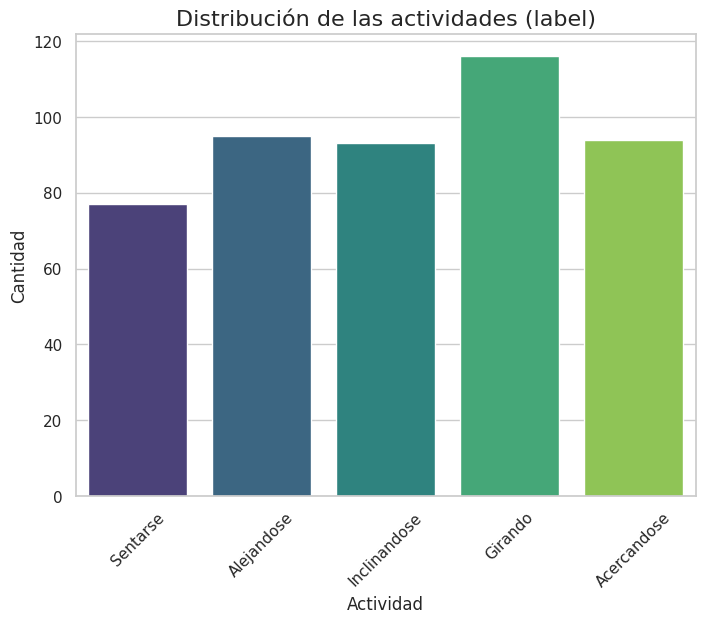

In [ ]:
sns.set(style="whitegrid")

# 1. Gráfico de barras para la distribución de 'label'
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribución de las actividades (label)', fontsize=16)
plt.xlabel('Actividad', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Varianza explicada por cada componente principal:
Componente 1: 0.3297
Componente 2: 0.2419
Componente 3: 0.1768
Componente 4: 0.0692
Componente 5: 0.0481
Componente 6: 0.0333
Componente 7: 0.0221
Componente 8: 0.0144
Componente 9: 0.0113
Componente 10: 0.0082
Componente 11: 0.0060
Componente 12: 0.0047
Componente 13: 0.0042
Componente 14: 0.0031
Componente 15: 0.0028
Componente 16: 0.0023
Componente 17: 0.0021
Componente 18: 0.0018
Componente 19: 0.0017
Componente 20: 0.0014
Componente 21: 0.0013
Componente 22: 0.0011
Componente 23: 0.0011
Componente 24: 0.0010


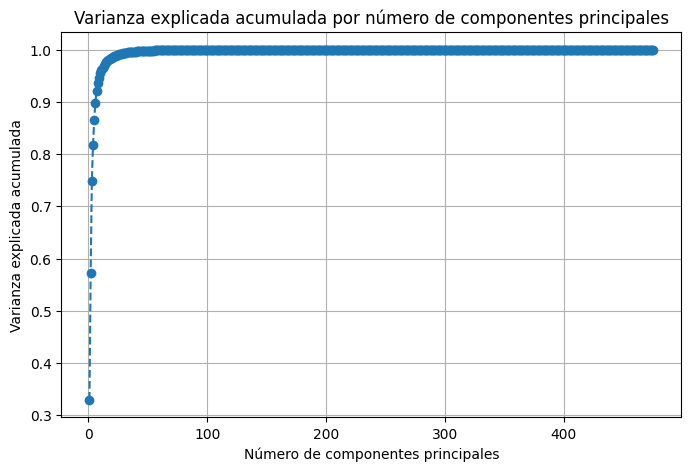

In [12]:
#Calcular la varianza explicada acumulada
data_2=df.drop('label', axis=1)
X = StandardScaler().fit_transform(data_2)
pca = PCA()  # Reduce to 2 dimensions for visualization
pca.fit(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#Imprimir la varianza explicada por cada componente principal
print("Varianza explicada por cada componente principal:")
for i, var_exp in enumerate(explained_variance_ratio):
  if var_exp > 0.001:
    print(f"Componente {i + 1}: {var_exp:.4f}")

#Graficar la varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

**Componente 1:** Explica el 32.97% de la varianza total. Este primer componente captura la mayor parte de la información o variabilidad de los datos originales.

**Componente 2:** Explica el 24.19%, sumando ya un 57.16% en conjunto con el primero.

**Componente 3:** Explica el 17.68%, y con los tres primeros componentes se explica el 74.84% de la varianza total.

Esto implica que los tres primeros componentes principales explican cerca del 75% de la varianza total, lo que significa que gran parte de la información del conjunto de datos está contenida en estas tres primeras dimensiones.

Después del componente 3, la varianza explicada por cada componente adicional es significativamente menor. Por ejemplo:

**Componente 4:** Explica solo el 6.92%.

**Componente 5:** Explica el 4.81%.

Componentes a partir del 10 explican cada uno menos del 1% de la varianza.

Podemos concluir que con los primeros 10 componentes podemos explicar cerca del 95% de la vrianza total, con lo cual, podemos reducir la dimensionalidad del conjunto de datos y trabajar con estos sin perder una cantidad significativa de información.

<ipython-input-42-bfbec0d5864c>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  label_colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(unique_labels)}


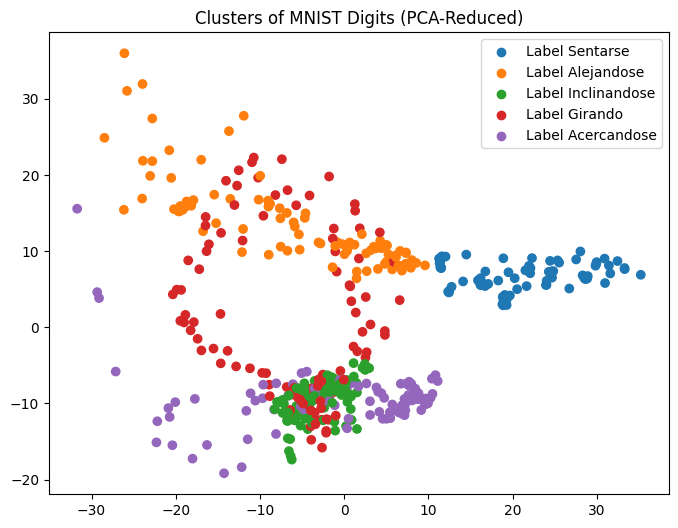

In [42]:
labels = df['label']

data_2=df.drop('label', axis=1)

X = StandardScaler().fit_transform(data_2)

pca = PCA(n_components=10)  # Reduce to 10 dimensions for visualization
reduced_data = pca.fit_transform(X)

# Create a color map for each unique label
unique_labels = labels.unique()
label_colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(unique_labels)}

# Assign colors to data points based on their labels
colors = [label_colors[label] for label in labels]


plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors)
plt.title("Clusters of MNIST Digits (PCA-Reduced)")

# Create a legend to show which color represents each label
for label, color in label_colors.items():
  plt.scatter([], [], color=color, label=f'Label {label}')

plt.legend()
plt.show()

**Agrupación de Clases:** Las diferentes etiquetas (Sentarse, Alejándose, Inclinándose, Girando, Acercándose) están representadas por distintos colores en el gráfico. El PCA ha reducido las dimensiones de los datos, lo que permite visualizar cómo se agrupan estos movimientos en un espacio bidimensional.

**Separación de Grupos:**

* Los puntos con las etiquetas Alejándose (color naranja) y Acercándose (color púrpura) parecen estar bastante bien definidos, con una separación clara del resto de los movimientos. Esto sugiere que estas acciones tienen características distintivas que son capturadas efectivamente por las primeras dos componentes principales.
* Las etiquetas Inclinandose (color verde) y Girando (color rojo) muestran cierta superposición, lo que indica que estas acciones comparten patrones similares en los datos de características, lo que dificulta su separación clara en este espacio reducido.
* La etiqueta Sentarse (color azul) también está algo separada, pero parece mezclarse con las otras etiquetas, lo que indica que este movimiento podría ser más ambiguo o tener características similares a otros movimientos.

**Interpretación de la Dispersión:** La dispersión dentro de los grupos también es relevante. Los clusters más dispersos sugieren que las acciones correspondientes tienen una mayor variabilidad en las características de movimiento. Por otro lado, los grupos más compactos, como en el caso de Inclinandose, sugieren una menor variabilidad y mayor consistencia dentro de esos patrones de movimiento.

**Sobreposición y Ambigüedad:** La presencia de sobreposición entre algunos grupos indica que puede haber similitudes en las posiciones de las articulaciones para esas acciones, lo que podría afectar la capacidad del modelo para diferenciarlas claramente. Esto podría ser un área para mejorar la precisión mediante el uso de técnicas adicionales.

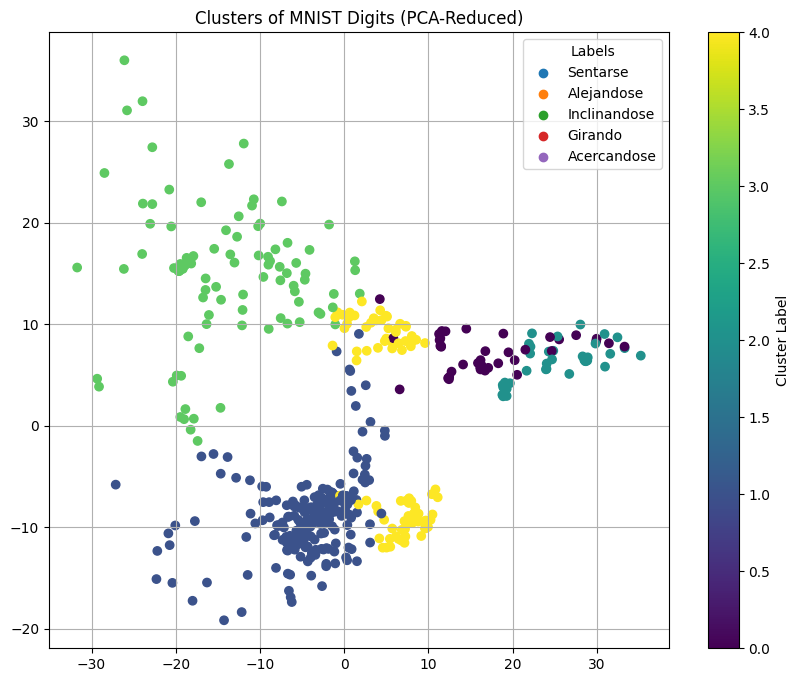

In [43]:
labels = df['label']
data_2 = df.drop('label', axis=1)

# Escalar los datos y aplicar PCA
X = StandardScaler().fit_transform(data_2)
pca = PCA(n_components=10)  # Reducir a 10 dimensiones para visualización
reduced_data = pca.fit_transform(X)

# Aplicar KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0, n_init=2)
cluster_labels = kmeans.fit_predict(reduced_data)

# Crear el gráfico
plt.figure(figsize=(10, 8))

# Utilizar un mapa de colores para las etiquetas de los clusters
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')

# Crear una leyenda para los clusters
unique_labels = labels.unique()
for label in unique_labels:
    plt.scatter([], [], label=label)  # Crear un marcador vacío con la etiqueta

plt.legend(title="Labels")
plt.title("Clusters of MNIST Digits (PCA-Reduced)")
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

Identificación de Grupos: El gráfico muestra cinco grupos de puntos (clusters), cada uno representado por un color diferente. Estos clusters indican que los datos tienen patrones que permiten agruparlos según características comunes tras la reducción de dimensionalidad con PCA. La separación visual de los grupos sugiere que el modelo de K-means ha logrado detectar diferencias significativas entre los patrones de movimiento de las articulaciones.

Separación y Solapamiento: Hay algunos grupos que están claramente separados de los demás, lo que es una buena señal de que las características extraídas (coordenadas x, y, z de las articulaciones) permiten distinguir diferentes patrones de acción. Sin embargo, también hay ciertas áreas donde los puntos de distintos colores se solapan o se encuentran muy cerca unos de otros. Esto indica que hay similitudes en las posiciones de las articulaciones para esos puntos, lo que puede dificultar que el modelo separe correctamente las acciones.

Compactación de Clusters: Algunos clusters parecen estar más compactos que otros. Los grupos más compactos indican que hay menos variabilidad entre los datos dentro de ese cluster, lo que sugiere que los movimientos de las articulaciones son más consistentes para esa acción específica. Por otro lado, los clusters más dispersos podrían representar acciones que tienen mayor variabilidad en las posiciones de las articulaciones o que son menos definidas.

